# DREAMER Feature Importance Analysis

This notebook performs comprehensive feature importance analysis for the DREAMER dataset.

**Dataset Info:**
- 14 EEG channels: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
- Frequency bands: delta, theta, alpha, gamma
- Feature types: PSD (Power Spectral Density) and Shannon entropy features
- Uses `features_table_psd_shannon.csv`

**Analysis Methods:**
1. Correlation Analysis (Pearson & Spearman)
2. Statistical Tests (ANOVA F-test, Mutual Information)
3. Random Forest Feature Importance
4. Permutation Importance
5. Linear SVM Coefficients

**Outputs:**
- `dreamer_feature_importance_valence.csv`
- `dreamer_feature_importance_arousal.csv`
- Visualizations for top features, bands, and channels

## Configuration

In [1]:
# Configurable parameters
TOP_N_FEATURES = 30       # Number of features shown in tables
TOP_N_VISUALIZE = 20      # Number of features in plots
TOP_N_AGGREGATE = 50      # Features in final aggregated ranking
BINARIZE_THRESHOLD = 3.0  # Threshold for binarizing 1-5 rating scale (>3 = High, <=3 = Low)

## 1. Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [20]:
# Load the PSD Shannon feature file
df = pd.read_csv('../datasets/Dreamer/features_table_updated.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns

Dataset shape: (42389, 159)
Columns: ['Unnamed: 0', 'patient_index', 'video_index', 'arousal', 'valence', 'AF3_delta', 'AF3_theta', 'AF3_alpha', 'AF3_betaL', 'AF3_betaH']...


In [21]:
# Separate features and labels
label_cols = ['valence', 'arousal', 'dominance']
# Exclude metadata/ID columns from features (patient_index, video_index, Unnamed: 0)
id_cols = ['patient_index', 'video_index', 'Unnamed: 0']
# Also check for other common ID columns if they exist
other_id_cols = ['ID', 'video'] if 'ID' in df.columns else (['video'] if 'video' in df.columns else [])
id_cols = id_cols + [col for col in other_id_cols if col not in id_cols]

# Get feature columns (all except labels and IDs)
feature_cols = [col for col in df.columns if col not in label_cols + id_cols]

X = df[feature_cols].values
y_valence = df['valence'].values
y_arousal = df['arousal'].values

print(f"Features: {len(feature_cols)} columns")
print(f"Samples: {X.shape[0]}")
print(f"\nExcluded columns: {id_cols}")
print(f"\nFirst 10 feature names: {feature_cols[:10]}")
print(f"\nLabel distributions:")
print(f"  Valence range: [{y_valence.min():.1f}, {y_valence.max():.1f}]")
print(f"  Arousal range: [{y_arousal.min():.1f}, {y_arousal.max():.1f}]")

Features: 154 columns
Samples: 42389

Excluded columns: ['patient_index', 'video_index', 'Unnamed: 0']

First 10 feature names: ['AF3_delta', 'AF3_theta', 'AF3_alpha', 'AF3_betaL', 'AF3_betaH', 'AF3_gamma', 'F7_delta', 'F7_theta', 'F7_alpha', 'F7_betaL']

Label distributions:
  Valence range: [2.0, 4.0]
  Arousal range: [1.0, 4.0]


## 2. Data Quality Check

In [22]:
# Check for NaN and infinite values
print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)

nan_counts = np.isnan(X).sum(axis=0)
inf_counts = np.isinf(X).sum(axis=0)
invalid_ratio = (nan_counts + inf_counts) / X.shape[0]

print(f"\nTotal features: {X.shape[1]}")
print(f"Features with NaN values: {(nan_counts > 0).sum()}")
print(f"Features with inf values: {(inf_counts > 0).sum()}")
print(f"Features with >50% invalid values: {(invalid_ratio > 0.5).sum()}")

# Show features with high invalid ratio
problematic_features = invalid_ratio > 0.5
if problematic_features.any():
    print("\nProblematic features (>50% invalid):")
    for idx in np.where(problematic_features)[0][:10]:  # Show first 10
        print(f"  {feature_cols[idx]}: {invalid_ratio[idx]*100:.1f}% invalid")

DATA QUALITY CHECK

Total features: 154
Features with NaN values: 0
Features with inf values: 0
Features with >50% invalid values: 0


## 3. Data Cleaning Strategy

In [23]:
print("=" * 60)
print("APPLYING DATA CLEANING")
print("=" * 60)

# Step 1: Remove features with >50% invalid values
features_to_keep = invalid_ratio <= 0.5
X_clean = X[:, features_to_keep]
feature_cols_clean = [feature_cols[i] for i in range(len(feature_cols)) if features_to_keep[i]]

print(f"\nStep 1: Removed {(~features_to_keep).sum()} features with >50% invalid values")
print(f"Remaining features: {X_clean.shape[1]}")

# Step 2: Replace inf with NaN (so imputer can handle them)
X_clean = np.where(np.isinf(X_clean), np.nan, X_clean)

# Step 3: Impute remaining NaN values with median
imputer = SimpleImputer(strategy='median')
X_clean = imputer.fit_transform(X_clean)

print(f"Step 2: Replaced inf values with NaN")
print(f"Step 3: Imputed remaining NaN values with median")

# Verify no NaN or inf remain
remaining_nan = np.isnan(X_clean).sum()
remaining_inf = np.isinf(X_clean).sum()
print(f"\nVerification:")
print(f"  NaN values remaining: {remaining_nan}")
print(f"  Inf values remaining: {remaining_inf}")

# Update X and feature_cols to use cleaned version
X = X_clean
feature_cols = feature_cols_clean

print(f"\nCleaned dataset ready: {X.shape[0]} samples × {X.shape[1]} features")

APPLYING DATA CLEANING

Step 1: Removed 0 features with >50% invalid values
Remaining features: 154
Step 2: Replaced inf values with NaN
Step 3: Imputed remaining NaN values with median

Verification:
  NaN values remaining: 0
  Inf values remaining: 0

Cleaned dataset ready: 42389 samples × 154 features


## 4. Normalize Features

In [24]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sanity check after normalization
print(f"After normalization:")
print(f"  NaN values: {np.isnan(X_scaled).sum()}")
print(f"  Inf values: {np.isinf(X_scaled).sum()}")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")

After normalization:
  NaN values: 0
  Inf values: 0
  Mean: -0.000000
  Std: 1.000000


## 5. Binarize Labels

In [25]:
# Binarize labels (DREAMER uses 1-5 scale)
# High: >3, Low: <=3
y_valence_binary = (y_valence > BINARIZE_THRESHOLD).astype(int)
y_arousal_binary = (y_arousal > BINARIZE_THRESHOLD).astype(int)

print(f"Valence distribution: High={y_valence_binary.sum()}, Low={len(y_valence_binary) - y_valence_binary.sum()}")
print(f"Arousal distribution: High={y_arousal_binary.sum()}, Low={len(y_arousal_binary) - y_arousal_binary.sum()}")

Valence distribution: High=14744, Low=27645
Arousal distribution: High=1843, Low=40546


## 6. Method 1: Correlation Analysis

In [26]:
def compute_correlations(X, y, feature_names):
    """Compute Pearson and Spearman correlations."""
    results = []
    
    for i, fname in enumerate(feature_names):
        pearson_corr, _ = pearsonr(X[:, i], y)
        spearman_corr, _ = spearmanr(X[:, i], y)
        
        results.append({
            'feature': fname,
            'pearson': abs(pearson_corr),
            'spearman': abs(spearman_corr),
            'avg_correlation': (abs(pearson_corr) + abs(spearman_corr)) / 2
        })
    
    return pd.DataFrame(results).sort_values('avg_correlation', ascending=False)

# Compute for both targets
corr_valence = compute_correlations(X_scaled, y_valence_binary, feature_cols)
corr_arousal = compute_correlations(X_scaled, y_arousal_binary, feature_cols)

print("Top features by correlation (Valence):")
print(corr_valence.head(TOP_N_FEATURES))
print("\nTop features by correlation (Arousal):")
print(corr_arousal.head(TOP_N_FEATURES))

Top features by correlation (Valence):
              feature   pearson  spearman  avg_correlation
93         T8_entropy  0.228352  0.235543         0.231947
102  AF4_AF3_theta_da  0.214348  0.187351         0.200849
95         F4_entropy  0.210697  0.190539         0.200618
103  AF4_AF3_theta_ra  0.210757  0.187351         0.199054
86         F3_entropy  0.201875  0.187639         0.194757
88         T7_entropy  0.191766  0.189954         0.190860
10           F7_betaH  0.214839  0.164797         0.189818
40           O1_betaH  0.187605  0.190923         0.189264
46           O2_betaH  0.187216  0.175668         0.181442
52           P8_betaH  0.182744  0.168486         0.175615
34           P7_betaH  0.203419  0.142743         0.173081
85         F7_entropy  0.178465  0.167552         0.173008
70           F4_betaH  0.184538  0.147121         0.165829
84        AF3_entropy  0.164397  0.166830         0.165614
75           F8_betaL  0.097556  0.227940         0.162748
98   AF4_AF3_gamm

## 7. Method 2: Statistical Tests (F-test, Mutual Information)

In [27]:
def compute_statistical_scores(X, y, feature_names):
    """Compute F-test and Mutual Information scores."""
    f_scores, _ = f_classif(X, y)
    mi_scores = mutual_info_classif(X, y, random_state=42)
    
    # Normalize scores to 0-1 range for comparison
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    f_scores_norm = scaler.fit_transform(f_scores.reshape(-1, 1)).flatten()
    mi_scores_norm = scaler.fit_transform(mi_scores.reshape(-1, 1)).flatten()
    
    results = pd.DataFrame({
        'feature': feature_names,
        'f_score': f_scores_norm,
        'mutual_info': mi_scores_norm,
        'avg_statistical': (f_scores_norm + mi_scores_norm) / 2
    }).sort_values('avg_statistical', ascending=False)
    
    return results

stat_valence = compute_statistical_scores(X_scaled, y_valence_binary, feature_cols)
stat_arousal = compute_statistical_scores(X_scaled, y_arousal_binary, feature_cols)

print("Top features by statistical tests (Valence):")
print(stat_valence.head(TOP_N_FEATURES))
print("\nTop features by statistical tests (Arousal):")
print(stat_arousal.head(TOP_N_FEATURES))

Top features by statistical tests (Valence):
              feature   f_score  mutual_info  avg_statistical
70           F4_betaH  0.640838     1.000000         0.820419
34           P7_betaH  0.784640     0.704694         0.744667
40           O1_betaH  0.663104     0.643218         0.653161
4           AF3_betaH  0.639207     0.655172         0.647190
10           F7_betaH  0.879596     0.374005         0.626801
46           O2_betaH  0.660260     0.581544         0.620902
93         T8_entropy  1.000000     0.186654         0.593327
102  AF4_AF3_theta_da  0.875384     0.298809         0.587097
52           P8_betaH  0.628012     0.538800         0.583406
103  AF4_AF3_theta_ra  0.844945     0.298827         0.571886
82          AF4_betaH  0.371115     0.687803         0.529459
95         F4_entropy  0.844445     0.208631         0.526538
86         F3_entropy  0.772269     0.203520         0.487894
16           F3_betaH  0.418079     0.551136         0.484608
88         T7_entropy  0.

## 8. Method 3: Random Forest Feature Importance

In [28]:
def compute_rf_importance(X, y, feature_names):
    """Compute Random Forest feature importance."""
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    results = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return results

rf_valence = compute_rf_importance(X_scaled, y_valence_binary, feature_cols)
rf_arousal = compute_rf_importance(X_scaled, y_arousal_binary, feature_cols)

print("Top features by Random Forest (Valence):")
print(rf_valence.head(TOP_N_FEATURES))
print("\nTop features by Random Forest (Arousal):")
print(rf_arousal.head(TOP_N_FEATURES))

Top features by Random Forest (Valence):
              feature  importance
70           F4_betaH    0.051736
83          AF4_gamma    0.030993
4           AF3_betaH    0.027799
82          AF4_betaH    0.025656
68           F4_alpha    0.023203
40           O1_betaH    0.022286
71           F4_gamma    0.020787
69           F4_betaL    0.020480
81          AF4_betaL    0.016313
34           P7_betaH    0.016082
58           T8_betaH    0.015030
5           AF3_gamma    0.014615
10           F7_betaH    0.014269
39           O1_betaL    0.012075
16           F3_betaH    0.011768
59           T8_gamma    0.011730
66           F4_delta    0.011724
46           O2_betaH    0.011359
103  AF4_AF3_theta_ra    0.011235
67           F4_theta    0.010962
75           F8_betaL    0.010746
28           T7_betaH    0.010730
22          FC5_betaH    0.010651
27           T7_betaL    0.010191
11           F7_gamma    0.009935
102  AF4_AF3_theta_da    0.009443
106    F4_F3_gamma_da    0.009432
31     

## 9. Method 4: Permutation Importance

In [29]:
def compute_permutation_importance(X, y, feature_names):
    """Compute permutation importance."""
    # Use a simpler model for faster computation
    model = LinearSVC(random_state=42, max_iter=2000)
    model.fit(X, y)
    
    perm_importance = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    results = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    return results

print("Computing permutation importance for Valence...")
perm_valence = compute_permutation_importance(X_scaled, y_valence_binary, feature_cols)

print("Computing permutation importance for Arousal...")
perm_arousal = compute_permutation_importance(X_scaled, y_arousal_binary, feature_cols)

print("\nTop features by Permutation Importance (Valence):")
print(perm_valence.head(TOP_N_FEATURES))
print("\nTop features by Permutation Importance (Arousal):")
print(perm_arousal.head(TOP_N_FEATURES))

Computing permutation importance for Valence...
Computing permutation importance for Arousal...

Top features by Permutation Importance (Valence):
              feature  importance
120    F8_F7_alpha_da    0.146842
106    F4_F3_gamma_da    0.113386
4           AF3_betaH    0.109448
115    F8_F7_gamma_ra    0.104303
121    F8_F7_alpha_ra    0.100484
114    F8_F7_gamma_da    0.087832
151    O2_O1_theta_ra    0.083347
102  AF4_AF3_theta_da    0.074182
150    O2_O1_theta_da    0.074109
107    F4_F3_gamma_ra    0.068480
124  FC6_FC5_delta_da    0.058904
125  FC6_FC5_delta_ra    0.055852
141    P8_P7_delta_ra    0.055408
34           P7_betaH    0.050815
147    O2_O1_gamma_ra    0.046484
129  FC6_FC5_alpha_ra    0.044726
128  FC6_FC5_alpha_da    0.043636
95         F4_entropy    0.042874
140    P8_P7_delta_da    0.042702
146    O2_O1_gamma_da    0.042282
144    P8_P7_alpha_da    0.037949
84        AF3_entropy    0.037923
10           F7_betaH    0.036450
112    F4_F3_alpha_da    0.034290
93 

## 10. Method 5: Linear SVM Coefficients

In [30]:
def compute_svm_weights(X, y, feature_names):
    """Compute Linear SVM coefficient weights."""
    svm = LinearSVC(random_state=42, max_iter=2000)
    svm.fit(X, y)
    
    results = pd.DataFrame({
        'feature': feature_names,
        'weight': np.abs(svm.coef_[0])
    }).sort_values('weight', ascending=False)
    
    return results

svm_valence = compute_svm_weights(X_scaled, y_valence_binary, feature_cols)
svm_arousal = compute_svm_weights(X_scaled, y_arousal_binary, feature_cols)

print("Top features by SVM weights (Valence):")
print(svm_valence.head(TOP_N_FEATURES))
print("\nTop features by SVM weights (Arousal):")
print(svm_arousal.head(TOP_N_FEATURES))

Top features by SVM weights (Valence):
            feature    weight
4         AF3_betaH  4.974810
28         T7_betaH  3.528928
52         P8_betaH  2.365096
49         P8_theta  1.970518
34         P7_betaH  1.883135
70         F4_betaH  1.198737
40         O1_betaH  1.139278
120  F8_F7_alpha_da  0.917814
10         F7_betaH  0.888991
20        FC5_alpha  0.884933
13         F3_theta  0.860311
26         T7_alpha  0.840670
106  F4_F3_gamma_da  0.741760
44         O2_alpha  0.724560
50         P8_alpha  0.702063
15         F3_betaL  0.682756
41         O1_gamma  0.682700
64        FC6_betaH  0.682278
69         F4_betaL  0.661970
43         O2_theta  0.648113
115  F8_F7_gamma_ra  0.612811
51         P8_betaL  0.610244
55         T8_theta  0.606601
121  F8_F7_alpha_ra  0.605897
19        FC5_theta  0.581240
16         F3_betaH  0.580948
114  F8_F7_gamma_da  0.557498
150  O2_O1_theta_da  0.534866
22        FC5_betaH  0.529520
53         P8_gamma  0.526217

Top features by SVM weights (A

## 11. Aggregate Rankings Across All Methods

In [31]:
def aggregate_rankings(corr_df, stat_df, rf_df, perm_df, svm_df, top_n=TOP_N_AGGREGATE):
    """Aggregate rankings from all 5 methods."""
    from sklearn.preprocessing import MinMaxScaler
    
    # Create a master dataframe
    master = pd.DataFrame({'feature': feature_cols})
    
    # Add normalized scores from each method
    scaler = MinMaxScaler()
    
    # Correlation
    corr_scores = corr_df.set_index('feature')['avg_correlation'].reindex(feature_cols).fillna(0)
    master['corr_score'] = scaler.fit_transform(corr_scores.values.reshape(-1, 1)).flatten()
    
    # Statistical
    stat_scores = stat_df.set_index('feature')['avg_statistical'].reindex(feature_cols).fillna(0)
    master['stat_score'] = scaler.fit_transform(stat_scores.values.reshape(-1, 1)).flatten()
    
    # Random Forest
    rf_scores = rf_df.set_index('feature')['importance'].reindex(feature_cols).fillna(0)
    master['rf_score'] = scaler.fit_transform(rf_scores.values.reshape(-1, 1)).flatten()
    
    # Permutation
    perm_scores = perm_df.set_index('feature')['importance'].reindex(feature_cols).fillna(0)
    master['perm_score'] = scaler.fit_transform(perm_scores.values.reshape(-1, 1)).flatten()
    
    # SVM
    svm_scores = svm_df.set_index('feature')['weight'].reindex(feature_cols).fillna(0)
    master['svm_score'] = scaler.fit_transform(svm_scores.values.reshape(-1, 1)).flatten()
    
    # Average all scores
    master['avg_score'] = master[['corr_score', 'stat_score', 'rf_score', 'perm_score', 'svm_score']].mean(axis=1)
    
    return master.sort_values('avg_score', ascending=False).head(top_n)

agg_valence = aggregate_rankings(corr_valence, stat_valence, rf_valence, perm_valence, svm_valence)
agg_arousal = aggregate_rankings(corr_arousal, stat_arousal, rf_arousal, perm_arousal, svm_arousal)

print(f"Top {TOP_N_AGGREGATE} features (aggregated across all methods) - Valence:")
print(agg_valence)
print(f"\nTop {TOP_N_AGGREGATE} features (aggregated across all methods) - Arousal:")
print(agg_arousal)

Top 50 features (aggregated across all methods) - Valence:
              feature  corr_score  stat_score  rf_score  perm_score  \
4           AF3_betaH    0.525064    0.787070  0.525734    0.746234   
70           F4_betaH    0.706496    1.000000  1.000000    0.078895   
34           P7_betaH    0.738687    0.906887  0.293584    0.348334   
40           O1_betaH    0.810525    0.794410  0.416516    0.215664   
102  AF4_AF3_theta_da    0.861953    0.713205  0.162051    0.506908   
10           F7_betaH    0.812985    0.762008  0.257665    0.250853   
52           P8_betaH    0.749935    0.708668  0.122933    0.131054   
93         T8_entropy    1.000000    0.720863  0.038077    0.226790   
28           T7_betaH    0.485515    0.415190  0.187553    0.163809   
106    F4_F3_gamma_da    0.372954    0.476139  0.161843    0.772954   
95         F4_entropy    0.860927    0.638767  0.017141    0.294446   
46           O2_betaH    0.775803    0.754758  0.200015    0.030610   
103  AF4_AF3_theta

## 12. Save Results to CSV

In [32]:
# Save the aggregated results
agg_valence.to_csv('dreamer_feature_importance_valence.csv', index=False)
agg_arousal.to_csv('dreamer_feature_importance_arousal.csv', index=False)

print("Results saved:")
print("  - dreamer_feature_importance_valence.csv")
print("  - dreamer_feature_importance_arousal.csv")

Results saved:
  - dreamer_feature_importance_valence.csv
  - dreamer_feature_importance_arousal.csv


## 13. Visualizations

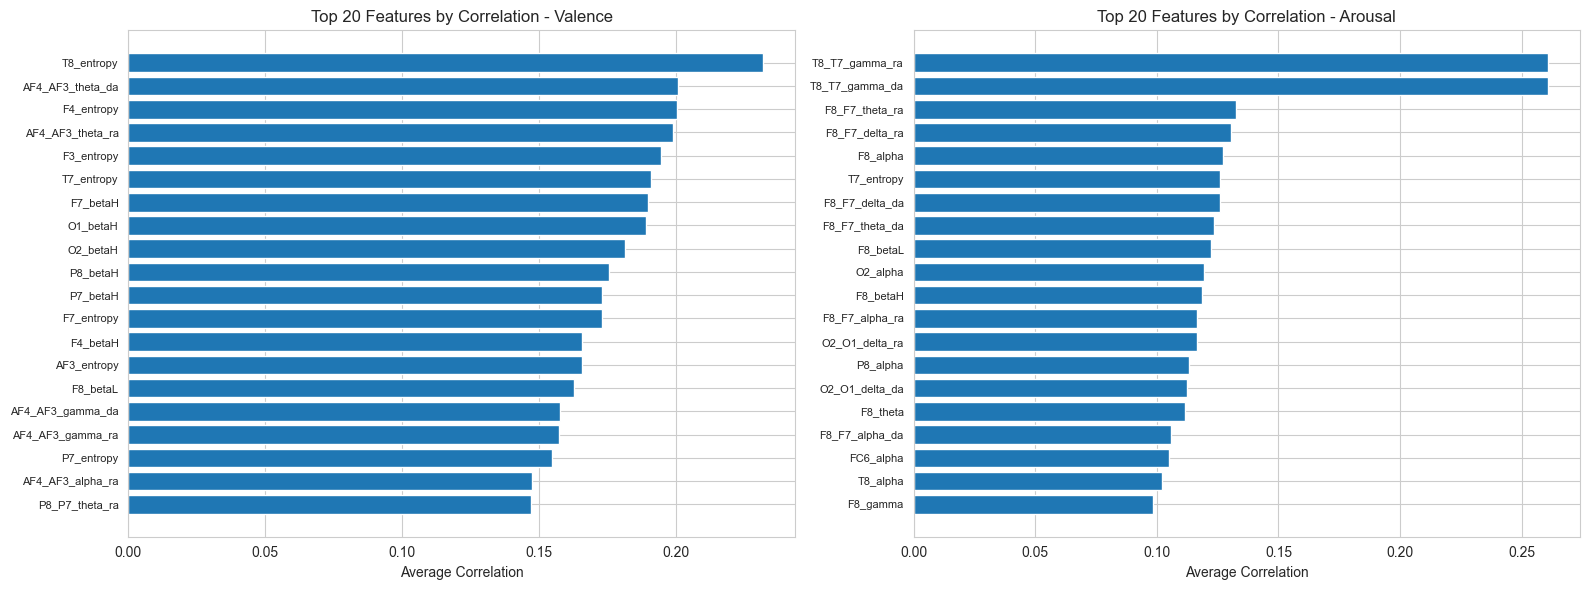

In [33]:
# Plot 1: Top features by correlation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Valence
top_corr_val = corr_valence.head(TOP_N_VISUALIZE)
axes[0].barh(range(len(top_corr_val)), top_corr_val['avg_correlation'])
axes[0].set_yticks(range(len(top_corr_val)))
axes[0].set_yticklabels(top_corr_val['feature'], fontsize=8)
axes[0].set_xlabel('Average Correlation')
axes[0].set_title(f'Top {TOP_N_VISUALIZE} Features by Correlation - Valence')
axes[0].invert_yaxis()

# Arousal
top_corr_aro = corr_arousal.head(TOP_N_VISUALIZE)
axes[1].barh(range(len(top_corr_aro)), top_corr_aro['avg_correlation'])
axes[1].set_yticks(range(len(top_corr_aro)))
axes[1].set_yticklabels(top_corr_aro['feature'], fontsize=8)
axes[1].set_xlabel('Average Correlation')
axes[1].set_title(f'Top {TOP_N_VISUALIZE} Features by Correlation - Arousal')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('dreamer_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

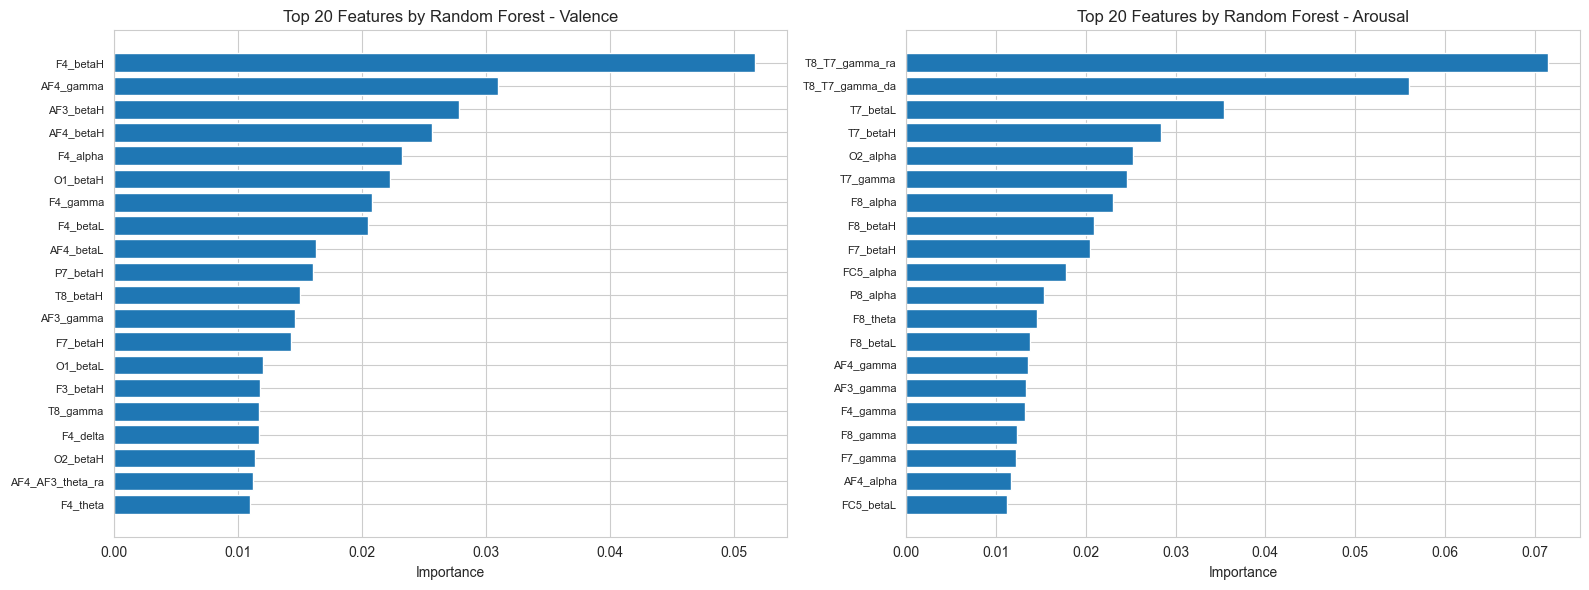

In [34]:
# Plot 2: Top features by Random Forest
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Valence
top_rf_val = rf_valence.head(TOP_N_VISUALIZE)
axes[0].barh(range(len(top_rf_val)), top_rf_val['importance'])
axes[0].set_yticks(range(len(top_rf_val)))
axes[0].set_yticklabels(top_rf_val['feature'], fontsize=8)
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {TOP_N_VISUALIZE} Features by Random Forest - Valence')
axes[0].invert_yaxis()

# Arousal
top_rf_aro = rf_arousal.head(TOP_N_VISUALIZE)
axes[1].barh(range(len(top_rf_aro)), top_rf_aro['importance'])
axes[1].set_yticks(range(len(top_rf_aro)))
axes[1].set_yticklabels(top_rf_aro['feature'], fontsize=8)
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Top {TOP_N_VISUALIZE} Features by Random Forest - Arousal')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('dreamer_random_forest_importance.png', dpi=300, bbox_inches='tight')
plt.show()

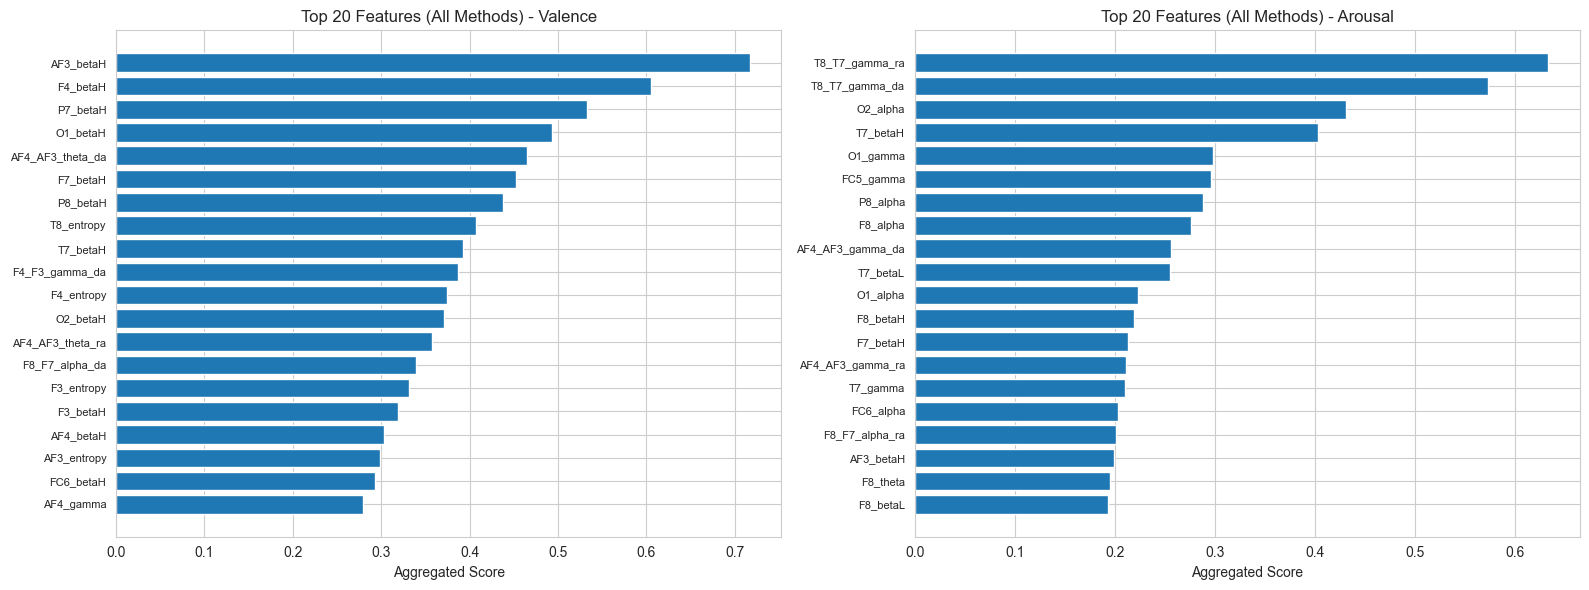

In [35]:
# Plot 3: Top features aggregated across all methods
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Valence
top_agg_val = agg_valence.head(TOP_N_VISUALIZE)
axes[0].barh(range(len(top_agg_val)), top_agg_val['avg_score'])
axes[0].set_yticks(range(len(top_agg_val)))
axes[0].set_yticklabels(top_agg_val['feature'], fontsize=8)
axes[0].set_xlabel('Aggregated Score')
axes[0].set_title(f'Top {TOP_N_VISUALIZE} Features (All Methods) - Valence')
axes[0].invert_yaxis()

# Arousal
top_agg_aro = agg_arousal.head(TOP_N_VISUALIZE)
axes[1].barh(range(len(top_agg_aro)), top_agg_aro['avg_score'])
axes[1].set_yticks(range(len(top_agg_aro)))
axes[1].set_yticklabels(top_agg_aro['feature'], fontsize=8)
axes[1].set_xlabel('Aggregated Score')
axes[1].set_title(f'Top {TOP_N_VISUALIZE} Features (All Methods) - Arousal')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('dreamer_top_features_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Analysis Summary

In [36]:
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nDataset: DREAMER (PSD Shannon features)")
print(f"Total features analyzed: {len(feature_cols)}")
print(f"Total samples: {X.shape[0]}")
print(f"\nConfiguration:")
print(f"  - TOP_N_FEATURES: {TOP_N_FEATURES}")
print(f"  - TOP_N_VISUALIZE: {TOP_N_VISUALIZE}")
print(f"  - TOP_N_AGGREGATE: {TOP_N_AGGREGATE}")
print(f"  - BINARIZE_THRESHOLD: {BINARIZE_THRESHOLD}")
print(f"\nOutputs generated:")
print(f"  - dreamer_feature_importance_valence.csv")
print(f"  - dreamer_feature_importance_arousal.csv")
print(f"  - dreamer_correlation_analysis.png")
print(f"  - dreamer_random_forest_importance.png")
print(f"  - dreamer_top_features_aggregated.png")
print(f"\nNext steps:")
print(f"  1. Review the CSV files for detailed rankings")
print(f"  2. Run DREAMER_Create_Filtered_Dataset.ipynb to generate filtered datasets")
print(f"  3. Train models on filtered datasets for faster training and better interpretability")

FEATURE IMPORTANCE ANALYSIS COMPLETE

Dataset: DREAMER (PSD Shannon features)
Total features analyzed: 154
Total samples: 42389

Configuration:
  - TOP_N_FEATURES: 30
  - TOP_N_VISUALIZE: 20
  - TOP_N_AGGREGATE: 50
  - BINARIZE_THRESHOLD: 3.0

Outputs generated:
  - dreamer_feature_importance_valence.csv
  - dreamer_feature_importance_arousal.csv
  - dreamer_correlation_analysis.png
  - dreamer_random_forest_importance.png
  - dreamer_top_features_aggregated.png

Next steps:
  1. Review the CSV files for detailed rankings
  2. Run DREAMER_Create_Filtered_Dataset.ipynb to generate filtered datasets
  3. Train models on filtered datasets for faster training and better interpretability
